# Using Clustering to Clean Up Data
## Local Setup

In order to run these examples locally, you need to set up a [Python 3.x](https://de.wikipedia.org/wiki/Python_(Programmiersprache)) environment. A simple way to do this under Windows or Mac OS is to use [Anaconda](https://www.anaconda.com/) which comes with most of the packages you will need to run the following tutorial.

If you have downloaded this tutorial (in form of a Jupyter notebook), make sure that you open it from within [Juypter](https://jupyter.org/) by running the following command from the command line (you might want to do this from the same directory, you have saved this file to avoid unnecessary browsing of your file system):
```
jupyter notebook
```
Further instructions are available in the [official documentation](https://jupyter.readthedocs.io/en/latest/running.html).

## Setup of the Environment

The only missing package is most likely Jellyfish, which provides support for string matching and offers such phonetic distance functions that we will need below. For further details, see the [Jellyfish homepage](https://pypi.python.org/pypi/jellyfish). The package can be installed by running the following command from this Juypter notebook.

In [105]:
!pip install jellyfish

In [106]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import itertools
import os.path
from datetime import datetime # for time measurement
import sys
import os
import pickle
import gzip
import math
import codecs

from jellyfish import jaro_distance, jaro_winkler, hamming_distance, levenshtein_distance, metaphone, nysiis, soundex
import scipy.cluster.hierarchy as scipycluster
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial import distance
# import the k-means algorithm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin,pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def pickleCompress(fileName,pickledObject):
    printLog("Pickling to '%s'" %fileName)
    f = gzip.open(fileName,'wb')
    pickle.dump(pickledObject,f)
    f.close()
    printLog("Pickling done.")
    
def pickleDecompress(fileName):
    #restore the object
    printLog("Depickling from '%s'" %fileName)
    f = gzip.open(fileName,'rb')
    pickledObject = pickle.load(f)
    f.close()
    printLog("Depickling done.")
    return pickledObject

## Simple Clustering Example

First, we will set up a fairly simple example. Given a string with multiple city names, we create a list of the tokens by separating the string using whitespace. Subsequently, we print the resulting tokens.

In [107]:
words = u'Berlin Balin Cölln Köln'.split()
print(words)

print("Number of words: %i" % len(words))
for i,val in enumerate(words):
    print(str(i)+":\t "+str(val))

['Berlin', 'Balin', 'Cölln', 'Köln']
Number of words: 4
0:	 Berlin
1:	 Balin
2:	 Cölln
3:	 Köln


In order to calculate the similarity of the different tokens, we need some kind of measurement expressing the similarity of two strings.

One way to do this is to use the __jaro\_distance()__ provided by the Jellyfish pacakge (see above).
Unfortunately, the name of the function is quite misleading as it technically computes a similarity as illustrated below. A distance between two equal strings would be 0...

In [108]:
jaro_distance(u'Berlin',u'Berlin')

1.0

In order to determine the dissimilarity between each city name, we compute a so-called distance matrix. A square matrix whose diagonal is 0 as the distance between the same city name is 0 for obvious reasons. Each column and row of the matrix corresponds to a name pair. For instance, the first column stands for Berlin, the third row for Cölln.

In [109]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.triu_indices.html
# 2nd parameter:
# Diagonal above which to zero elements. k = 0 (the default) is the main diagonal, k < 0 is below it and k > 0 is above."""
# r= Return the indices for the upper-triangle of an (n, m) array. da m nicht angegeben ist, wird n=m angenommen
# m is not passed, hence m=n

# create a square matrix
r=np.triu_indices(n=len(words), k=1)
r

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

Our distance matrix is structured as follows:
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{a_{0,1}} & \underline{a_{0,2}} & \underline{a_{0,3}} \\
\cdot & a_{1,1} & \underline{a_{1,2}} & \underline{a_{1,3}} \\
\cdot & \cdot & a_{2,2} & \underline{a_{2,3}} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

To give an example, $a_{0,1}$ yields the difference between "Berlin" and "Balin".

In [110]:
def d_demo(coord):
    print(coord)
    i, j = coord
    # 1-distance is needed as the function yields a similarity (see above)
    return 1-jaro_distance(words[i], words[j])

In [111]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.set_printoptions.html
np.set_printoptions(precision=4)

# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d_demo, 0, r)
r2

[0 1]
[0 2]
[0 3]
[1 2]
[1 3]
[2 3]


array([0.1778, 0.4222, 0.3889, 0.4   , 0.3667, 0.2167])

If we map the resulting array back to a matrix, we obtain:
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{0.1778} & \underline{0.4222} & \underline{0.3889} \\
\cdot & a_{1,1} & \underline{0.4} & \underline{0.3667} \\
\cdot & \cdot & a_{2,2} & \underline{0.2167} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

That is, $a_{0,1}$, the difference between "Berlin" and "Balin", is 0.17777778. In other words, the strings are fairly similar (there is a low distance between them).

This triangle distance matrix forms the base for all following calculations as it expresses the distance between all tokens.

## Working with Real Data

First, we have to define the distance function to build our distance matrix as above.

In [112]:
def calculate_string_distance(coord):
    i, j = coord
    return 1-jaro_distance(words[i],words[j])

In the next cell, an number of city names is provided, feel free to add further cities by separating them with a comma. Do not miss to enclose every term with quotation marks.

Calling `words` directly tells the Jupyter notebook to output the content of the array

In [113]:
words=['Neon-Phaliron','Neon-Phalirou','Temesvár','Temeswar','Kolozsvártt','Kolozsvár','Kiøbenhavn','Kiøbenhavn','Kjøbenhavn','Kjøbenhavn','Kjöbenhavn','Kjøbenhavn','Kiøbenhavn','København','Kopenhagen','Copenhagen','Berlin','Bern','Berlino','Frankfurt/Main', 'Frankfurt/Oder', 'Frankfurt, Main',
       'Frankfurt, O', 'Frankfurt, Oder', 'Franckfurt', 'Franckfurth',
       'Frankfurt a. M.', 'Frankfurt', 'Frankfurt/ Main',
       'Frankfurt a.M.', 'Frankfurt, Oder?', 'Frankfurt a. O.','Francofurti','Lipsiae','Lipsiæ','Leipzig','Havniæ','Hanoviae','Hanoviae','Obernai','Oberhofen','Bernburg','Berlin-Dahlem','Steglitz-Berlin','Perlin','Balin','Bärlin','Bär','Bärn']
words

['Neon-Phaliron',
 'Neon-Phalirou',
 'Temesvár',
 'Temeswar',
 'Kolozsvártt',
 'Kolozsvár',
 'Kiøbenhavn',
 'Kiøbenhavn',
 'Kjøbenhavn',
 'Kjøbenhavn',
 'Kjöbenhavn',
 'Kjøbenhavn',
 'Kiøbenhavn',
 'København',
 'Kopenhagen',
 'Copenhagen',
 'Berlin',
 'Bern',
 'Berlino',
 'Frankfurt/Main',
 'Frankfurt/Oder',
 'Frankfurt, Main',
 'Frankfurt, O',
 'Frankfurt, Oder',
 'Franckfurt',
 'Franckfurth',
 'Frankfurt a. M.',
 'Frankfurt',
 'Frankfurt/ Main',
 'Frankfurt a.M.',
 'Frankfurt, Oder?',
 'Frankfurt a. O.',
 'Francofurti',
 'Lipsiae',
 'Lipsiæ',
 'Leipzig',
 'Havniæ',
 'Hanoviae',
 'Hanoviae',
 'Obernai',
 'Oberhofen',
 'Bernburg',
 'Berlin-Dahlem',
 'Steglitz-Berlin',
 'Perlin',
 'Balin',
 'Bärlin',
 'Bär',
 'Bärn']

Now, we will create a new distance matrix with the city names from above.

In [114]:
r=np.triu_indices(len(words), 1)
printLog("Started calculation of distance matrix for %i words..."%len(words))
# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(calculate_string_distance, 0, r)
printLog("Finished calculations.")

[2020-11-21 12:54:39.058579]	Started calculation of distance matrix for 49 words...
[2020-11-21 12:54:39.070292]	Finished calculations.


### Agglomerative Clustering

First, we give agglomerative/hierarchical clustering a try in order to inspect the results. For details, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html .

In [115]:
Z=scipycluster.linkage(r2)

A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

The result of the clustering algorithm can serve as input for a dendrogram plot, e.g., as described by
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/.

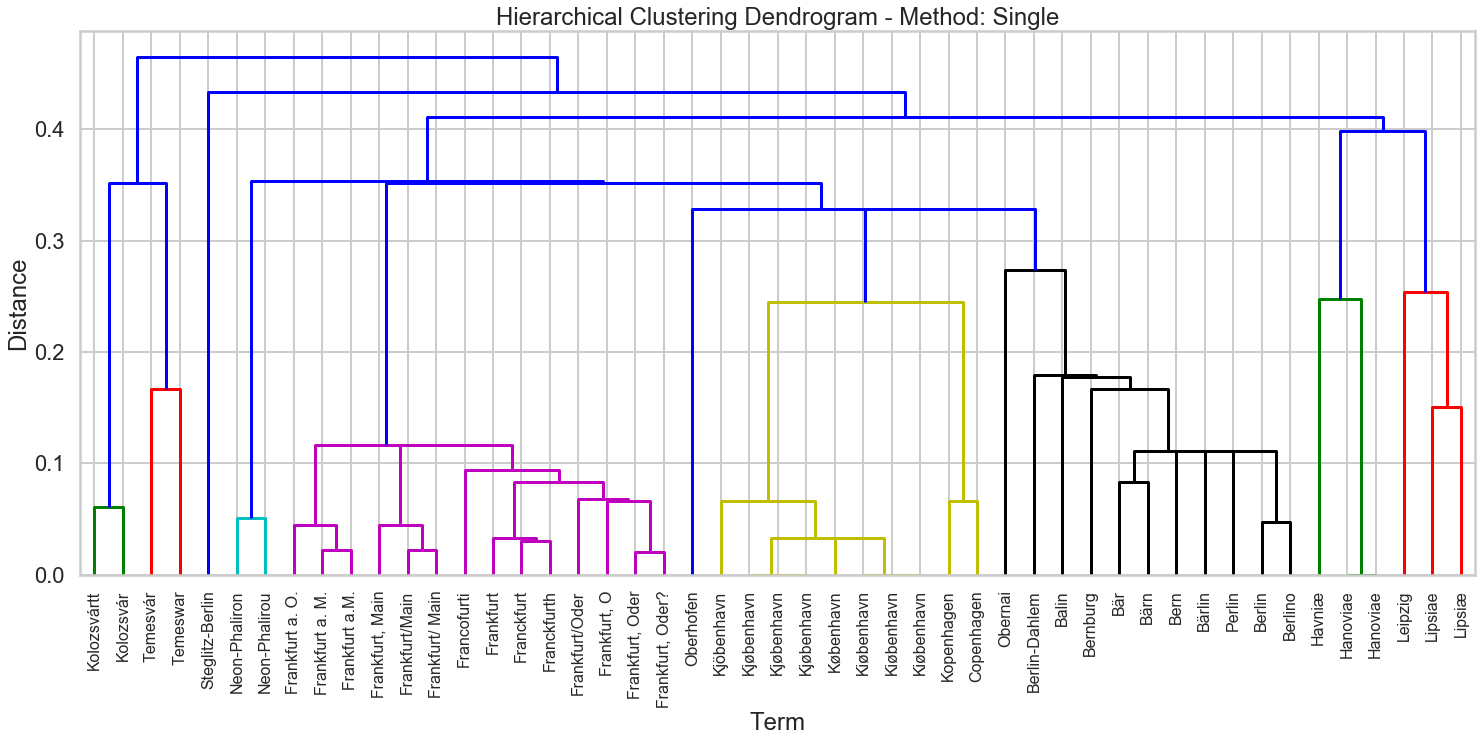

In [116]:
plt.figure(figsize=(25, 10))
method_name='single'
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term')
plt.ylabel('Distance')
scipycluster.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
    labels=words
    )
plt.show()

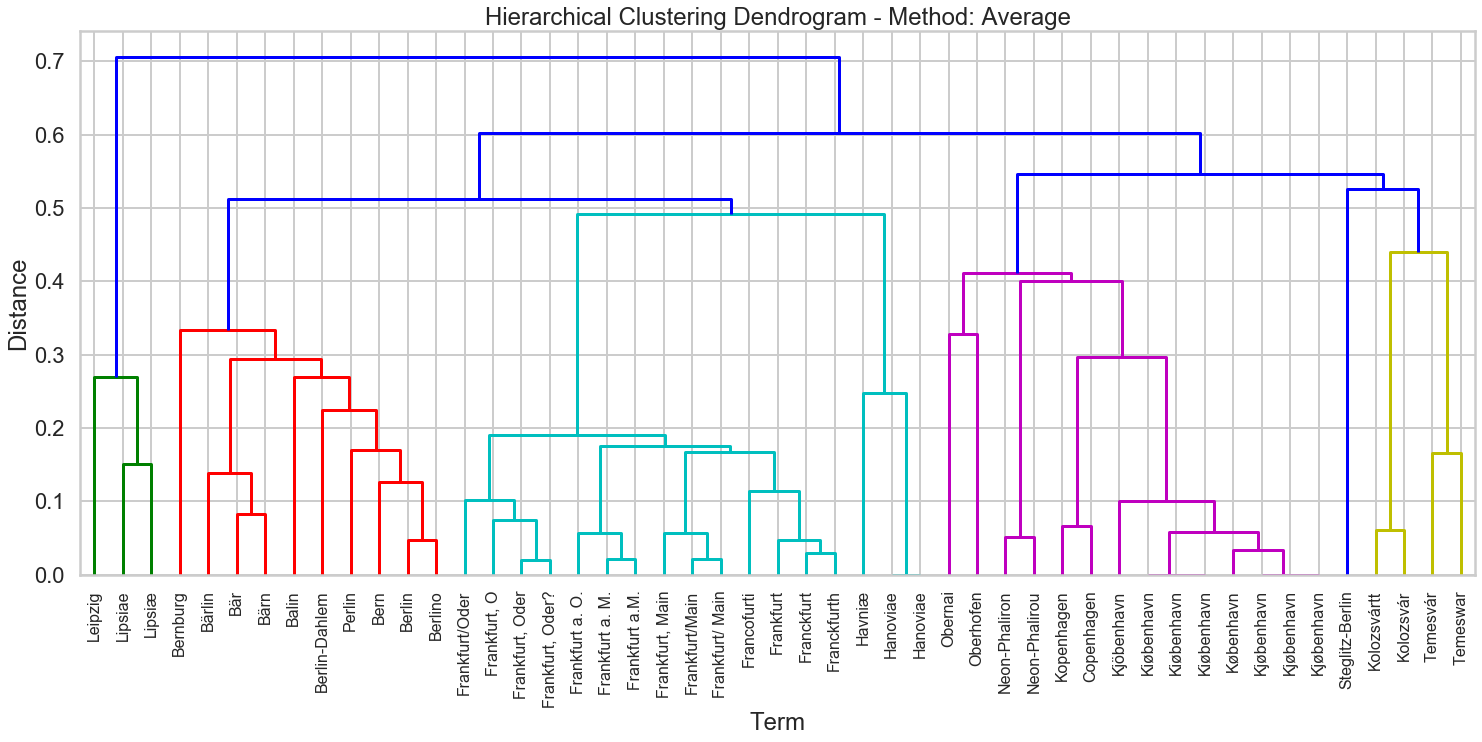

In [117]:
method_name='average'

Z=scipycluster.linkage(r2,method=method_name)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term')
plt.ylabel('Distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=words
    )
plt.show()

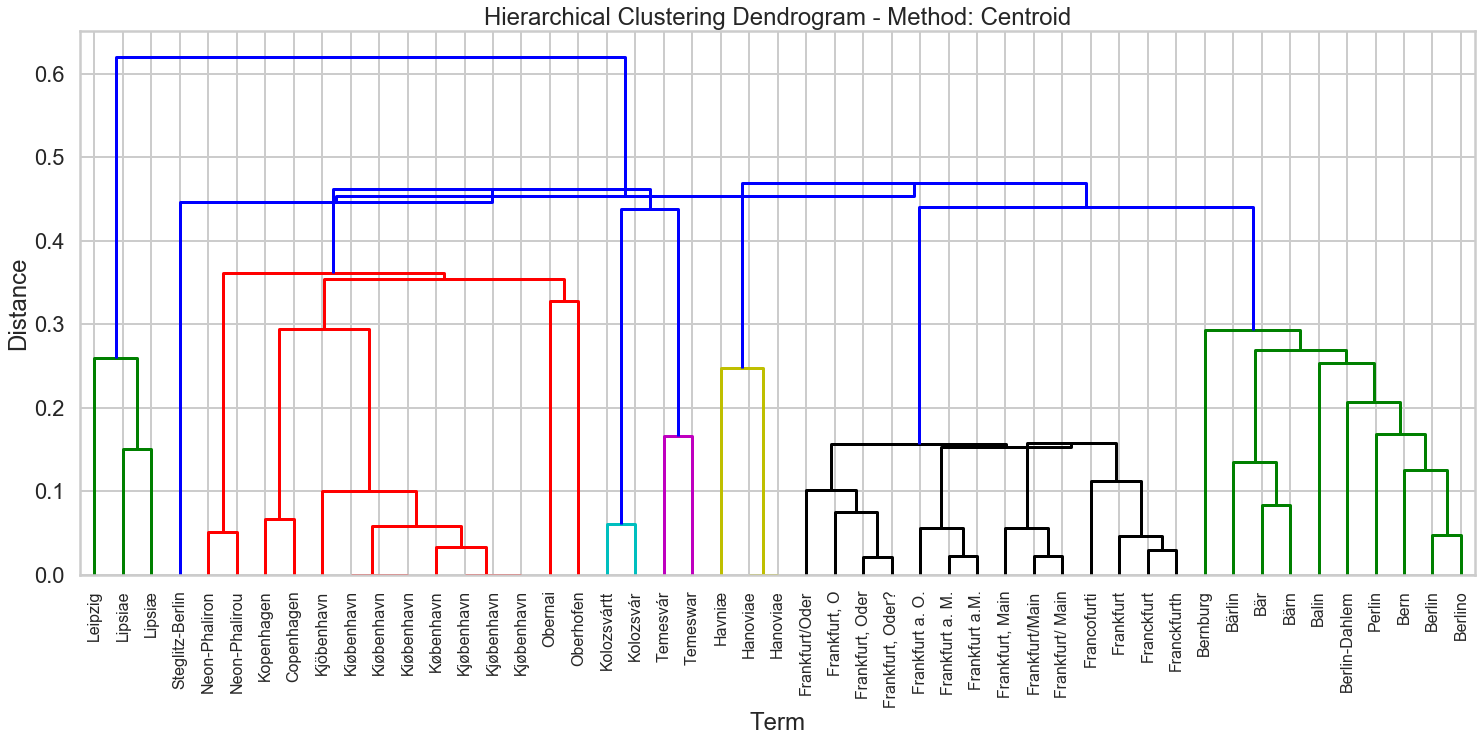

In [118]:
method_name='centroid'

Z=scipycluster.linkage(r2,method=method_name)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term')
plt.ylabel('Distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=words
    )
plt.show()

#### Samples with Phonetic Preprocessing

The following examples follow the logic presented above. However, the make use of the `metaphone` and `soundex` methods provided by Jellyfish to convert the tokens to their phonetic equivalents before creating the distance matrix and visualizing the results.

Number of words in metaphone format: 49
0:	 NNFLRN
1:	 NNFLR
2:	 TMSFR
3:	 TMSWR
4:	 KLSSFRT
5:	 KLSSFR
6:	 KBNHFN
7:	 KBNHFN
8:	 KJBNHFN
9:	 KJBNHFN
10:	 KJBNHFN
11:	 KJBNHFN
12:	 KBNHFN
13:	 KBNHFN
14:	 KPNHJN
15:	 KPNHJN
16:	 BRLN
17:	 BRN
18:	 BRLN
19:	 FRNKFRTMN
20:	 FRNKFRTTR
21:	 FRNKFRT MN
22:	 FRNKFRT O
23:	 FRNKFRT OTR
24:	 FRNKFRT
25:	 FRNKFR0
26:	 FRNKFRT A M
27:	 FRNKFRT
28:	 FRNKFRT MN
29:	 FRNKFRT AM
30:	 FRNKFRT OTR
31:	 FRNKFRT A O
32:	 FRNKFRT
33:	 LPX
34:	 LPS
35:	 LPSK
36:	 HFN
37:	 HNF
38:	 HNF
39:	 OBRN
40:	 OBRHFN
41:	 BRNBRK
42:	 BRLNTLM
43:	 STKLTSBRLN
44:	 PRLN
45:	 BLN
46:	 BRLN
47:	 BR
48:	 BRN


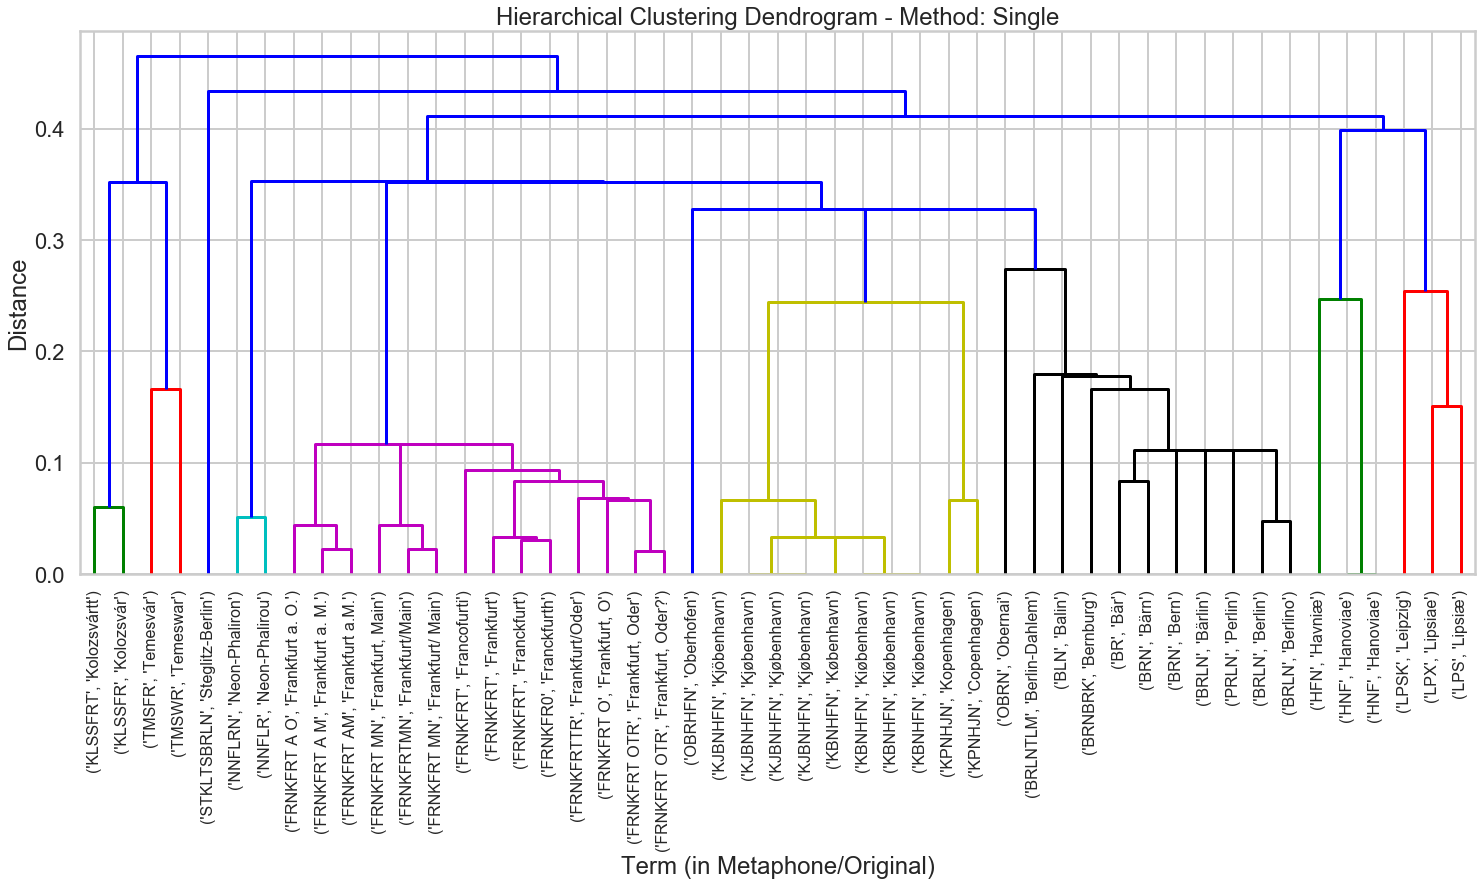

In [119]:
# create a new list of tokens by applying the metaphone method to all tokens from the words list
words2=list(map(metaphone,words))
term_labels=list(zip(words2,words))

print("Number of words in metaphone format: %i" % len(words2))
for i,val in enumerate(words2):
    print(str(i)+":\t "+str(val))

# calculate the triangle dis tance list as above
r=np.triu_indices(n=len(words2), k=1)
r

r2=np.apply_along_axis(d, 0, r)
r2

method_name='single'
Z=scipycluster.linkage(r2,method=method_name)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term (in Metaphone/Original)')
plt.ylabel('Distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=term_labels
    )
plt.show()

Number of words in metaphone format: 49
0:	 NNFLRN
1:	 NNFLR
2:	 TMSFR
3:	 TMSWR
4:	 KLSSFRT
5:	 KLSSFR
6:	 KBNHFN
7:	 KBNHFN
8:	 KJBNHFN
9:	 KJBNHFN
10:	 KJBNHFN
11:	 KJBNHFN
12:	 KBNHFN
13:	 KBNHFN
14:	 KPNHJN
15:	 KPNHJN
16:	 BRLN
17:	 BRN
18:	 BRLN
19:	 FRNKFRTMN
20:	 FRNKFRTTR
21:	 FRNKFRT MN
22:	 FRNKFRT O
23:	 FRNKFRT OTR
24:	 FRNKFRT
25:	 FRNKFR0
26:	 FRNKFRT A M
27:	 FRNKFRT
28:	 FRNKFRT MN
29:	 FRNKFRT AM
30:	 FRNKFRT OTR
31:	 FRNKFRT A O
32:	 FRNKFRT
33:	 LPX
34:	 LPS
35:	 LPSK
36:	 HFN
37:	 HNF
38:	 HNF
39:	 OBRN
40:	 OBRHFN
41:	 BRNBRK
42:	 BRLNTLM
43:	 STKLTSBRLN
44:	 PRLN
45:	 BLN
46:	 BRLN
47:	 BR
48:	 BRN


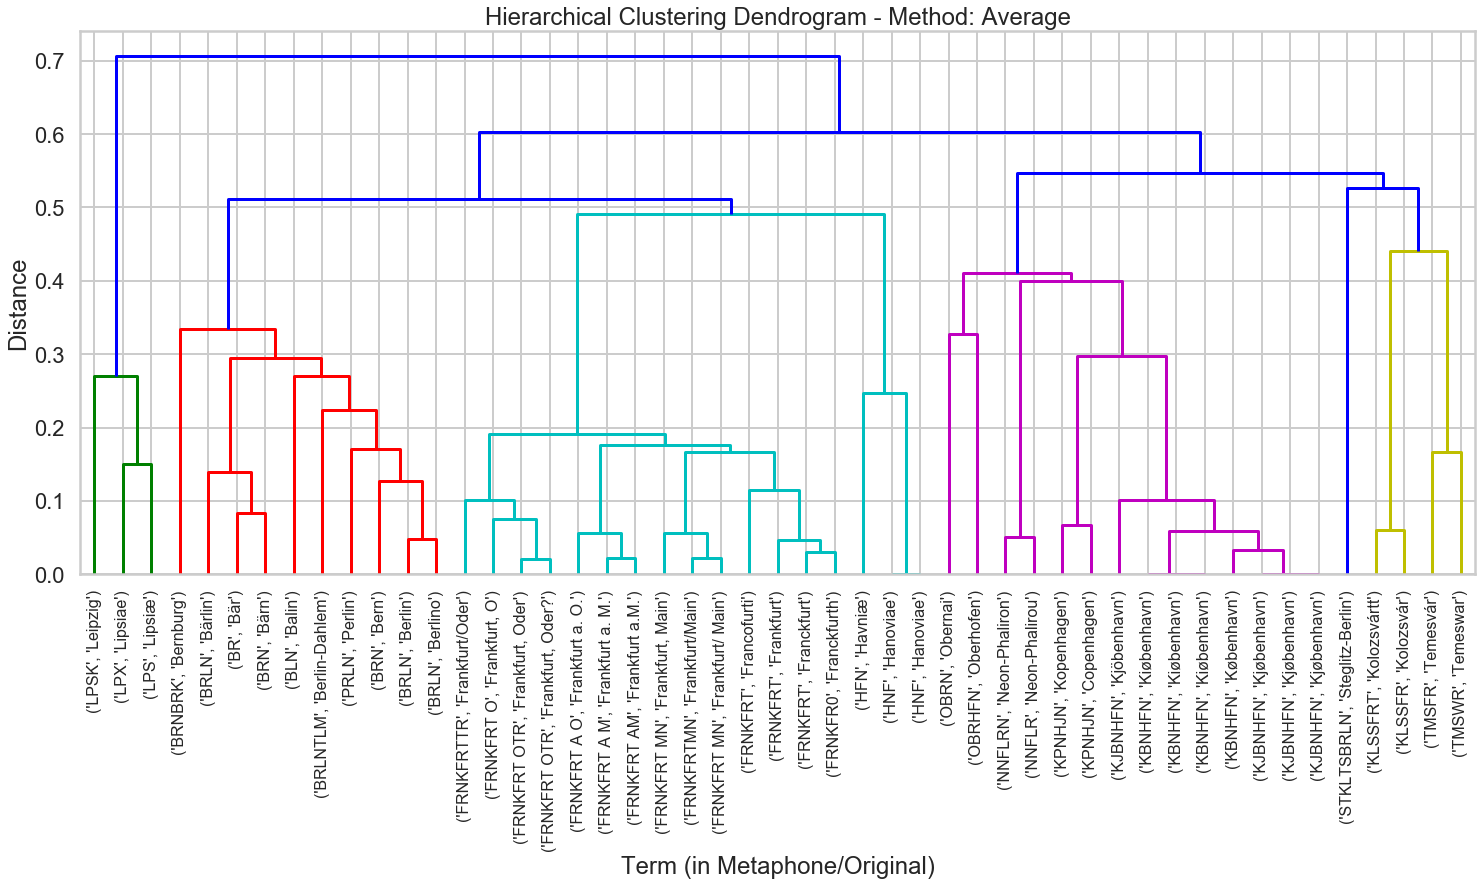

In [120]:
words2=list(map(metaphone,words))
term_labels=list(zip(words2,words))

print("Number of words in metaphone format: %i" % len(words2))
for i,val in enumerate(words2):
    print(str(i)+":\t "+str(val))
    
r=np.triu_indices(n=len(words2), k=1)
r

r2=np.apply_along_axis(d, 0, r)
r2

method_name='average'
Z=scipycluster.linkage(r2,method=method_name)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term (in Metaphone/Original)')
plt.ylabel('Distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=term_labels
    )
plt.show()

Number of words in soundex format: 49
0:	 N514
1:	 N514
2:	 T521
3:	 T526
4:	 K421
5:	 K421
6:	 K151
7:	 K151
8:	 K151
9:	 K151
10:	 K151
11:	 K151
12:	 K151
13:	 K151
14:	 K152
15:	 C152
16:	 B645
17:	 B650
18:	 B645
19:	 F652
20:	 F652
21:	 F652
22:	 F652
23:	 F652
24:	 F652
25:	 F652
26:	 F652
27:	 F652
28:	 F652
29:	 F652
30:	 F652
31:	 F652
32:	 F652
33:	 L120
34:	 L120
35:	 L122
36:	 H150
37:	 H510
38:	 H510
39:	 O165
40:	 O161
41:	 B651
42:	 B645
43:	 S324
44:	 P645
45:	 B450
46:	 B645
47:	 B600
48:	 B650


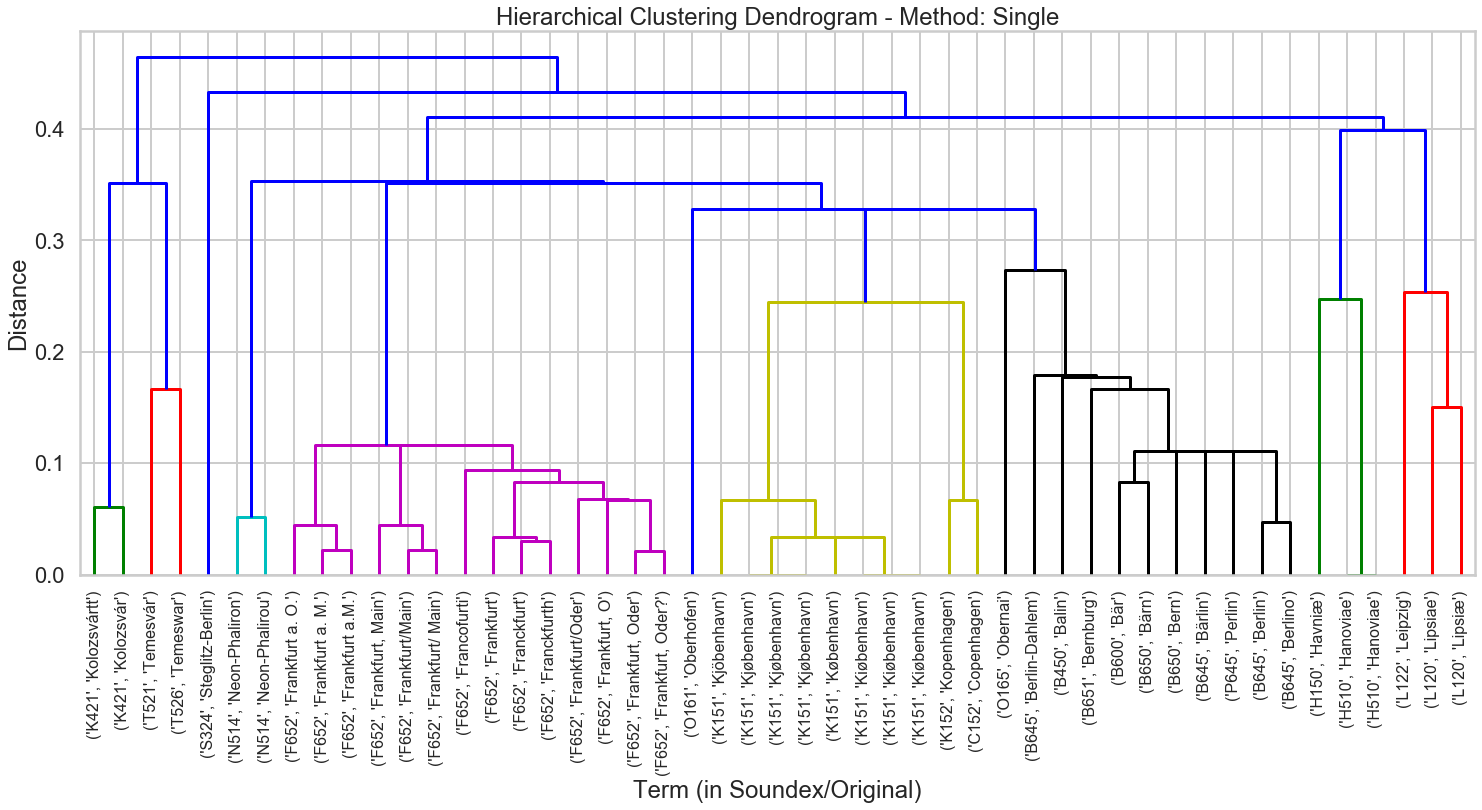

In [121]:
words2=list(map(soundex,words))
term_labels=list(zip(words2,words))

print("Number of words in soundex format: %i" % len(words2))
for i,val in enumerate(words2):
    print(str(i)+":\t "+str(val))
    
r=np.triu_indices(n=len(words2), k=1)
r

r2=np.apply_along_axis(d, 0, r)
r2

method_name='single'
Z=scipycluster.linkage(r2,method=method_name)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term (in Soundex/Original)')
plt.ylabel('Distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=term_labels
    )
plt.show()

Number of words in soundex format: 49
0:	 N514
1:	 N514
2:	 T521
3:	 T526
4:	 K421
5:	 K421
6:	 K151
7:	 K151
8:	 K151
9:	 K151
10:	 K151
11:	 K151
12:	 K151
13:	 K151
14:	 K152
15:	 C152
16:	 B645
17:	 B650
18:	 B645
19:	 F652
20:	 F652
21:	 F652
22:	 F652
23:	 F652
24:	 F652
25:	 F652
26:	 F652
27:	 F652
28:	 F652
29:	 F652
30:	 F652
31:	 F652
32:	 F652
33:	 L120
34:	 L120
35:	 L122
36:	 H150
37:	 H510
38:	 H510
39:	 O165
40:	 O161
41:	 B651
42:	 B645
43:	 S324
44:	 P645
45:	 B450
46:	 B645
47:	 B600
48:	 B650


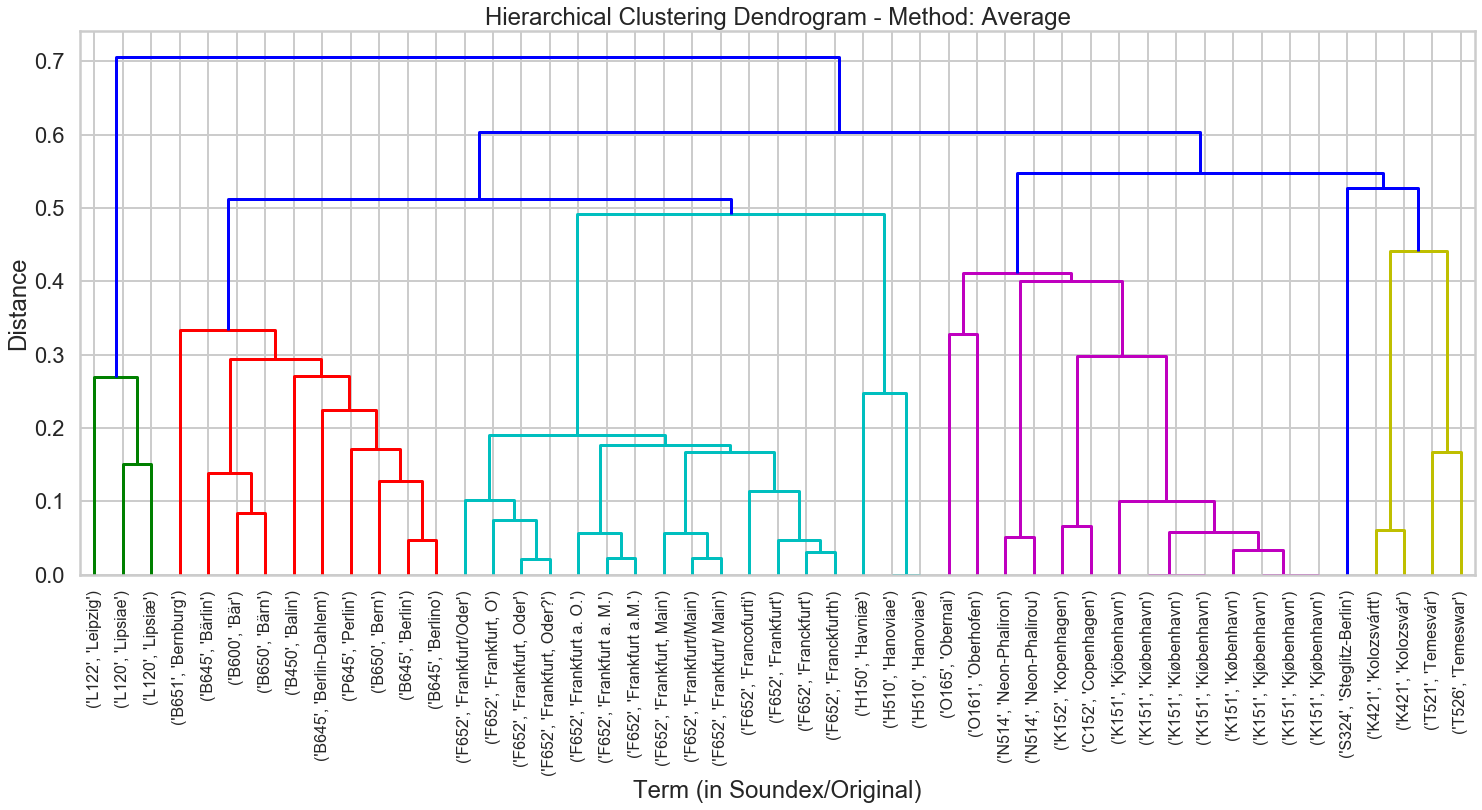

In [122]:
words2=list(map(soundex,words))
term_labels=list(zip(words2,words))

print("Number of words in soundex format: %i" % len(words2))
for i,val in enumerate(words2):
    print(str(i)+":\t "+str(val))
    
r=np.triu_indices(n=len(words2), k=1)
r

r2=np.apply_along_axis(d, 0, r)
r2

method_name='average'
Z=scipycluster.linkage(r2,method=method_name)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Method: '+method_name.title())
plt.xlabel('Term (in Soundex/Original)')
plt.ylabel('Distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=term_labels
    )
plt.show()